In [1]:
%matplotlib inline
from fgspectra import cross as fgc
from fgspectra import power as fgp
from fgspectra import frequency as fgf
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import sensitivity_calculator as sens
from scipy.optimize import minimize
import sys
sys.path.append('/root/')
import pcl_actpol_utility_v4 as pau
import emcee
import corner
import tqdm

def get_hivon_fsky(mask):
    npix = len(mask)
    non0 = np.where(mask!=0)[0]
    fs = len(non0)/float(npix)
    w2 = np.sum(mask[non0]**2)/(npix*fs)
    w4 = np.sum(mask[non0]**4)/(npix*fs)
    return fs*w2**2/w4


#range for power spectra
ells = np.arange(2, 8000)

#parameters for fgspectra
par = {
    "nu_0": 150.0,
    "ell_0": 3000,
    "T_CMB": 2.725,
    "T_d": 9.7,
    "a_tSZ": 4.66,
    "a_kSZ": 1.60,
    "a_p": 6.87,
    "beta_p": 2.08,
    "a_c": 6.10,
    "beta_c": 2.08,
    "n_CIBC": 1.20,
    "xi": 0.09,
    "a_s": 3.50,
    "a_g": 0.88,
}
# define the models from fgspectra
ksz = fgc.FactorizedCrossSpectrum(fgf.ConstantSED(), fgp.kSZ_bat())
cibp = fgc.FactorizedCrossSpectrum(fgf.ModifiedBlackBody(), fgp.PowerLaw())
radio = fgc.FactorizedCrossSpectrum(fgf.PowerLaw(), fgp.PowerLaw())
cirrus = fgc.FactorizedCrossSpectrum(fgf.PowerLaw(), fgp.PowerLaw())

# if there are correlations between components,
# have to define them in a joined spectrum
tSZ_and_CIB = fgc.CorrelatedFactorizedCrossSpectrum(
    fgf.Join(fgf.ThermalSZ(), fgf.CIB()), fgp.SZxCIB_Addison2012()
)

# for testing purposes we'll also compute the tSZ and clustered CIB alone
tsz = fgc.FactorizedCrossSpectrum(fgf.ThermalSZ(), fgp.tSZ_150_bat())
cibc = fgc.FactorizedCrossSpectrum(fgf.CIB(), fgp.PowerLaw())
def get_fg_model(freqs, ells, par):
    return (
        par["a_kSZ"] * ksz({"nu": freqs}, {"ell": ells, "ell_0": par["ell_0"]}),
        par["a_p"]
        * cibp(
            {
                "nu": freqs,
                "nu_0": par["nu_0"],
                "temp": par["T_d"],
                "beta": par["beta_p"],
            },
            {"ell": ells, "ell_0": par["ell_0"], "alpha": 2},
        ),
        # joint tSZ, CIB, and their correlation
        tSZ_and_CIB(
            {
                "kwseq": (
                    {"nu": freqs, "nu_0": par["nu_0"]},
                    {
                        "nu": freqs,
                        "nu_0": par["nu_0"],
                        "temp": par["T_d"],
                        "beta": par["beta_c"],
                    },
                )
            },
            {
                "kwseq": (
                    {"ell": ells, "ell_0": par["ell_0"], "amp": par["a_tSZ"]},
                    {
                        "ell": ells,
                        "ell_0": par["ell_0"],
                        "alpha": 2 - par["n_CIBC"],
                        "amp": par["a_c"],
                    },
                    {
                        "ell": ells,
                        "ell_0": par["ell_0"],
                        "amp": -par["xi"] * np.sqrt(par["a_tSZ"] * par["a_c"]),
                    },
                )
            },
        ),
        par["a_s"]
        * radio(
            {"nu": freqs, "nu_0": par["nu_0"], "beta": -0.5 - 2},
            {"ell": ells, "ell_0": par["ell_0"], "alpha": 2},
        ),
        par["a_g"]
        * cirrus(
            {"nu": freqs, "nu_0": par["nu_0"], "beta": 3.8 - 2},
            {"ell": ells, "ell_0": par["ell_0"], "alpha": -0.7},
        ),
        # THESE TWO ARE REDUDUNDANT, BUT USEFUL FOR TESTING
        par["a_tSZ"]
        * tsz({"nu": freqs, "nu_0": par["nu_0"]}, {"ell": ells, "ell_0": par["ell_0"]}),
        par["a_c"]
        * cibc(
            {
                "nu": freqs,
                "nu_0": par["nu_0"],
                "temp": par["T_d"],
                "beta": par["beta_c"],
            },
            {"ell": ells, "ell_0": par["ell_0"], "alpha": 2 - par["n_CIBC"]},
        ),
    )

#(env)$ python3 -m ipykernel install --user --name=env


###############################################################################################333
#use sensitivity calculator 
inputs = {'diameter': 5.7, 't': 273, 'wfe': 10.7, 'eta': 0.98, 'doe': 0.8, 't_int': 1, 'pixelYield': 0.8, 
        'szCamNumPoln': 1, 'eorSpecNumPoln': 2, 't_filter_cold': np.array([0.593, 0.84 , 0.86, 0.86, 0.89 ]), 
        't_lens_cold': np.array([0.98, 0.98, 0.98, 0.98, 0.98]), 
        't_uhdpe_window': np.array([0.96, 0.97, 0.97, 0.97, 0.97]), 
        'singleModedAOmegaLambda2': np.array([1., 1., 1., 1., 1.]), 
        'spatialPixels': np.array([39762, 20808, 10368, 10368,  7938]), 
        'eqbw': np.array([9.7e+10, 3.0e+10, 3.5e+10, 6.0e+10, 5.6e+10]), 
        'centerFrequency': np.array([8.50e+11, 4.05e+11, 3.48e+11, 2.80e+11, 2.22e+11]), 'detectorNEP': 0, 
        'backgroundSubtractionDegradationFactor': 1, 'r': np.array([[100., 100., 100.],
                                            [100., 100., 100.],
                                            [100., 100., 100.],
                                            [100., 100., 100.],
                                            [100., 100., 100.]]), 
        'decimalPlaces': 3, 'observationElevationAngle': 45, 'outputFreq': True, 
        'detectorSpacing': np.array([1.45, 1.97, 2.75, 2.75, 3.13]), 'lyotStopAngle': 13.4}
# Alternatively, sens.getInputs("input.yaml")


#spillEfficiency = sens.getSpillEfficiency(inputs, oldFile=False)
#print(spillEfficiency)
spillEfficiency = sens.getSpillEfficiency(inputs, oldFile=True)
#print(spillEfficiency)
# spillEfficienc#y = np.array([0.8,0.5,0.7,0.95,0.5])
calculate = sens.calcByAngle(inputs["diameter"], inputs["t"], inputs["wfe"], inputs["eta"], inputs["doe"], inputs["t_int"], inputs["pixelYield"], inputs["szCamNumPoln"], inputs["eorSpecNumPoln"],
                            inputs["t_filter_cold"], inputs["t_lens_cold"], inputs["t_uhdpe_window"], spillEfficiency, inputs["singleModedAOmegaLambda2"],
                            inputs["spatialPixels"], inputs["eqbw"], inputs["centerFrequency"], inputs["detectorNEP"],
                            inputs["backgroundSubtractionDegradationFactor"], inputs["r"])
outputs = calculate(45) #45 degree angle

#get noise from sens, by l, temp noise, and pol noise
ell, N_ell_T_full, N_ell_P_full = sens.getNoiseCurves(inputs, outputs)
dl = ell*(ell+1)/(2*np.pi)

#get sky fraction fsky
NSIDE = 1024
hitmap_path = "~/mask_share/ccat_uniform_coverage_nside" + str(NSIDE) + "_201021.fits"
mask_path = "~/mask_share/nside" + str(NSIDE) + "_lat_cut_b10_230619.fits"
hitm = hp.read_map(hitmap_path)
maskm = hp.read_map(mask_path)
#hp.mollview(hitm*maskm)
#hp.mollview(maskm)
fsky = np.sum(hitm*maskm)/len(hitm)
fsky = get_hivon_fsky(hitm*maskm)
########################################## FOR SO ONLY
fsky = 0.4
###########################################
print('fsky=%.4f'%fsky)



fsky=0.4000


In [1]:
#SO noise curves
from so_models_v3 import SO_Noise_Calculator_Public_v3_1_1 as SO_noise
mode = 'baseline'
so_fsky = 0.4
lat = SO_noise.SOLatV3point1(mode,survey_years=5.,survey_efficiency = 0.2*0.85)
lat_lmax = 10000

so_freq_list = np.array([25.7, 38.9, 92, 147.5, 225.7, 285.4])

ell_LA, N_ell_LA_T_full,N_ell_LA_P_full = lat.get_noise_curves(
        so_fsky, lat_lmax, 1, full_covar=False, deconv_beam=True)

'''
for curves, labels, title in zip([N_ell_LA_T_full], [so_freq_list], ["SO Noise Curves (T)"]):
    for curve, label in zip(curves, labels):
        plt.plot(ell_LA, curve, label=str(int(label))+' GHz')
    plt.yscale('log')
    plt.xscale('log')
    plt.xlim(10**2, 10**4)
    plt.ylim(10**-5, 10**3)
    plt.xlabel('$\ell$',fontsize=18)
    plt.ylabel('$N_\ell [\mu K^2]$',fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.title(title)
    plt.legend(loc='upper right')
    plt.grid()
    plt.show()

ccat_freq_list = np.array([8.50e+11, 4.05e+11, 3.48e+11, 2.80e+11, 2.22e+11])

for curves, labels, title in zip([N_ell_T_full], [ccat_freq_list], ["CCAT Noise Curves (T)"]):
    for curve, label in zip(curves, labels):
        plt.plot(ell, curve, label=str(int(label/1e9))+' GHz')
    plt.yscale('log')
    plt.xscale('log')
    plt.xlim(10**2, 10**4)
    plt.ylim(10**-5, 10**3)
    plt.xlabel('$\ell$',fontsize=18)
    plt.ylabel('$N_\ell [\mu K^2]$',fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.title(title)
    plt.legend(loc='upper right')
    plt.grid()
    plt.show()
'''

NameError: name 'np' is not defined

In [3]:
#Build signal and noise spectra

#band centers to consider
centerfreqs_full = np.array([25.7, 38.9, 92, 147.5, 225.7, 285.4]) #np.array([150]) # np.array([850.0, 405.0, 348.0, 280.0, 222.0]) #,150.0])
#frequency indices from sensitivity_calc
#[8.50e+11, 4.05e+11, 3.48e+11, 2.80e+11, 2.22e+11]
#    0          1        2         3         4
#frequency indices from SO freq list
#[25.7, 38.9, 92, 147.5, 225.7, 285.4]
#   0     1    2    3      4     5
#######################################
center_indices = [2]#,3,4]
#######################################
#N_l = [N_ell_T_full[i] for i in center_indices] #noise curves from sens
N_l = [N_ell_LA_T_full[i] for i in center_indices] #noise curves from SO
centerfreqs = np.array([centerfreqs_full[i] for i in center_indices])
n_freq = len(centerfreqs)
print(centerfreqs)

#generate spectra as seen by the center frequencies
C_l_full = get_fg_model(centerfreqs, ells, par)
#C_l[foreground spectrum index][center frequency index1, center frequency index2]
#spectra ['a_kSZ','a_p','tSZ_CIB','a_s','a_g','a_tSZ','a_c'] #spectra
#           0       1       2       3     4      5      6
###########################################
fore_indices = [5] #,0,6,3]
############################################
C_l = [C_l_full[i] for i in fore_indices]
n_fore = len(C_l)
print(fore_indices)

#mismatch/offset frequencies #TO DO: ADD FTS SCALED OFFSET
############################################
offset = 1 #GHz
###########################################
C_l_offset_full = get_fg_model(centerfreqs+offset, ells, par)
C_l_offset = [C_l_offset_full[i] for i in fore_indices]
'''
#     "a_tSZ": 4.66,
#     "a_kSZ": 1.60,
#     "a_p": 6.87,
#     "beta_p": 2.08,
#     "a_c": 6.10,
#     "beta_c": 2.08,
#     "n_CIBC": 1.20,
#     "xi": 0.09,
#     "a_s": 3.50,
#     "a_g": 0.88,
'''
a_true_full = {
    0: 1.60,  # a_kSZ
    1: 6.87,  # a_p
    2: 0.09,  # xi_tSZxCIB
    3: 3.50,  # a_s
    4: 0.88,  # a_g
    5: 4.66,  # a_tSZ
    6: 6.10,  # a_c
}
'''
# a_true_full = {
#     0: 1.0,  # a_kSZ
#     1: 1.0,  # a_p
#     2: 1.0,  # tSZxCIB
#     3: 1.0,  # a_s
#     4: 1.0,  # a_g
#     5: 1.0,  # a_tSZ
#     6: 1.0,  # a_c
# }
'''
a_true = [a_true_full[i] for i in fore_indices]
print(a_true)

labels_full = [
    r"$a_{\mathrm{kSZ}}$", 
    r"$a_p$", 
    r"$a_{\mathrm{tSZ}\times\mathrm{CIB}}$", 
    r"$a_s$", #radio
    r"$a_g$", #dust
    r"$a_{\mathrm{tSZ}}$", 
    r"$a_c$"
]
labels = [labels_full[i] for i in fore_indices]
print(labels)
# for f in range(n_freq):
#     for s in range(n_fore):
#         plt.plot(C_l[s][(f,f)], label=labels[s])
#     plt.legend(loc = 'upper right')
#     plt.yscale('log')
#     plt.xlim(-500,9000)
#     plt.ylim(10e-3,10e3)
#     plt.title(f"Foregrounds at {centerfreqs[f]}")
#     plt.gca().set_box_aspect(1)
#     plt.show()


[92.]
[5]
[4.66]
['$a_{\\mathrm{tSZ}}$']


In [ ]:

#from pcl_actpol_utility
def read_binfile(path,lcut=100000):
   lbands = np.array(np.genfromtxt('%s'%path)[:,:2],dtype='int')
   if len(np.where(lbands[:,1]>lcut)[0]) != 0:
      lbands = lbands[:len(lbands)-len(np.where(lbands[:,1]>lcut)[0])]
   if lbands[0,0] == 0:
      lbands[0,0] = 2
   return lbands

def get_lbands_all(lbands):
   nbins = len(lbands)
   lmax = lbands[-1, -1]
   ell = np.arange(lmax + 1)
   dl = ell*(ell+1)/(2*np.pi)

   band = np.zeros(nbins)
   ell_bin = np.zeros(nbins)

   for i in range(nbins):
      band[i] = (lbands[i,1]-lbands[i,0])/2.
      ell_bin[i] = (lbands[i,0]+lbands[i,1])/2.

   return (ell_bin, band, nbins, lmax, ell, dl)


lmax_cut = 8000
binfile = '/root/BIN_ACTPOL_50_4_SC_low_ell'
lbands = pau.read_binfile(binfile, lcut=lmax_cut)
print(lbands)
(ell_bin, band, nbins, lmax, elxx, dxx) = pau.get_lbands_all(lbands)
print(ell_bin)

#roughly eq 2.5 in steve paper https://arxiv.org/pdf/1509.05934
'''
def get_analytic_var_auto(fsky, ell_bin, lband_width):
   """ compute total variance for auto spectra:
       get sig(C_l) from C_l (Knox 1995)
       watch the lband_width input which is half the actual width
   """
   return np.sqrt(2.0 / ((2.0 * ell_bin + 1.0) * fsky * (lband_width * 2 + 1)))
'''
def get_analytic_var_cross(fsky, ell_bin, lband_width):
   """ compute total variance for cross spectra:
       get sig(C_l) from C_l (Knox 1995)
       watch the lband_width input which is half the actual width
   """
   return np.sqrt(2.0 / ((2.0 * ell_bin + 1.0) * fsky * (lband_width * 2 + 1)))/np.sqrt(2)

#g_fac ~= 1/sqrt(number of modes nu)
#used as 1/sqrt(nu) prefactor in cov matrix
g_fac = get_analytic_var_cross(fsky, ell_bin, band)
#quick nu_b from g_fac
#nu_b = 1/(g_fac[np.array(ell_bin-1.5,'int')].copy())**2
nu_b = 1/g_fac**2

59


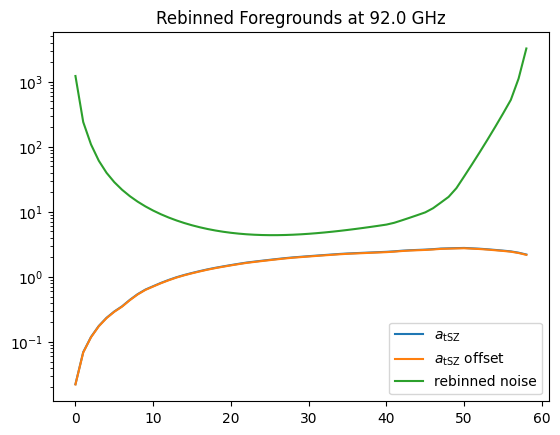

'\nplt.plot(g_fac, label="g_fac")\nplt.plot(nu_b,  label="nu_b")\nplt.yscale(\'log\')\nplt.title("g_fac and nu_b")\nplt.legend()\nplt.show()\n\nplt.plot(N_b[0], label=\'Noise f=0\')\nplt.plot(C_b[0][0,0], label=\'Signal s=0 f0f0\')\nplt.legend()\nplt.yscale(\'log\')\nplt.show()\n'

In [21]:
#quick rebin matching primecam_simulator
N_b = {}
for f1 in range(n_freq):
        N_b[f1] = (N_l[f1]*dl)[np.array(ell_bin-1.5,'int')].copy()

#59 bins
n_bins = N_b[0].shape[0]
print(n_bins)

C_b = {}
C_b_offset = {}
for s in range(n_fore):
    C_b[s] = {}
    C_b_offset[s] = {}
    for f1 in range(n_freq):
        for f2 in range(n_freq):
            ############################# HERE RESCALE FOREGROUNDS -> TEMPLATES ###########################
            C_b[s][f1,f2] = C_l[s][f1,f2][np.array(ell_bin-1.5,'int')].copy() / a_true[s]
            C_b_offset[s][f1,f2] = C_l_offset[s][f1,f2][np.array(ell_bin-1.5,'int')].copy() / a_true[s]
            ###############################################################################################

for s in range(n_fore):
    plt.plot(C_b[s][(0,0)], label=f'{labels[s]}')
    plt.plot(C_b_offset[s][(0,0)], label=f'{labels[s]} offset')
plt.plot(N_b[0], label='rebinned noise')
plt.legend()
plt.yscale('log')
plt.title(f"Rebinned Foregrounds at {centerfreqs[0]} GHz")
plt.show()
'''
plt.plot(g_fac, label="g_fac")
plt.plot(nu_b,  label="nu_b")
plt.yscale('log')
plt.title("g_fac and nu_b")
plt.legend()
plt.show()

plt.plot(N_b[0], label='Noise f=0')
plt.plot(C_b[0][0,0], label='Signal s=0 f0f0')
plt.legend()
plt.yscale('log')
plt.show()
'''

1


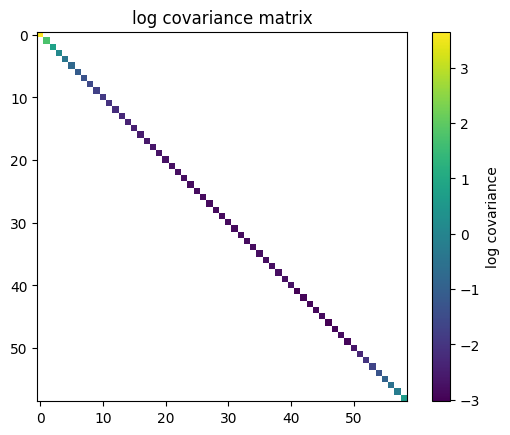

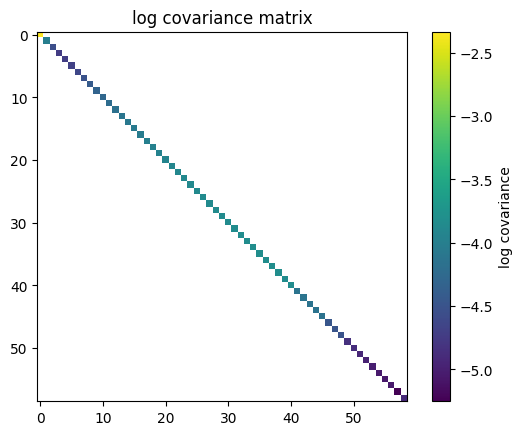

'\nplt.imshow((cov_total_full), cmap=\'viridis\')#, vmin=vmin, vmax=vmax)\nplt.colorbar(label=\'covariance\')\nplt.title("covariance matrix")\nplt.show()\n\ndef cov2corr(cov):\n    stddev = np.sqrt(np.diag(cov))\n    corr = cov / np.outer(stddev, stddev)\n    np.fill_diagonal(corr, 1.0)\n    return corr\n\ncorr_matrix = np.corrcoef(cov_total_full)\nplt.imshow(np.log10(corr_matrix), cmap=\'viridis\')#, vmin=vmin, vmax=vmax)\nplt.colorbar(label=\'log correlation\')\nplt.title("log correlation_matrix")\nplt.show()\nplt.imshow((corr_matrix), cmap=\'viridis\')#, vmin=vmin, vmax=vmax)\nplt.colorbar(label=\'correlation\')\nplt.title("correlation_matrix")\nplt.show()\n'

In [40]:
freq_pairs = []
pair_index = {}
k = 0
for f1 in range(n_freq):
    for f2 in range(f1, n_freq):
        freq_pairs.append((f1, f2))
        pair_index[(f1, f2)] = k
        pair_index[(f2, f1)] = k
        k += 1
n_pairs = len(freq_pairs)
print(n_pairs)

#######################################################################################
#function that automatically adds only auto spectra noise for a given frequency pair
def sig_noise(f1, f2):
    C_total = sum(C_b[s][f1, f2] for s in range(n_fore)) # sum C_b
    if f1 == f2: #only if this term has an auto spectra include noise
        C_total += N_b[f1]
    return C_total

######################################################################################
#returns correct-looking covmat
cov_matrix = np.zeros((n_bins, n_pairs, n_pairs))
for a in range(n_freq):
    for b in range(n_freq):
        for c in range(n_freq):
            for d in range(n_freq):
                i = pair_index[(a, b)]
                j = pair_index[(c, d)]
                c_ac = sig_noise(a, c)
                c_bd = sig_noise(b, d)
                c_ad = sig_noise(a, d)
                c_bc = sig_noise(b, c)
                for bin in range(n_bins):
                    cov_matrix[bin, i, j] = (1 / nu_b[bin]) * (c_ac[bin]*c_bd[bin] + c_ad[bin]*c_bc[bin])
                cov_matrix[:, j, i] = cov_matrix[:, i, j]

#form cov_matrix[bin, fpair_1, fpair_2]
block = [[np.zeros((n_bins, n_bins)) for j in range(n_pairs)] for i in range(n_pairs)]

# Fill only the diagonal of each (n_bins × n_bins) block from cov_matrix
for i in range(n_pairs):
    for j in range(n_pairs):
        for b in range(n_bins):
            block[i][j][b, b] = cov_matrix[b, i, j]
  
# blockshow = block[0][0]
# plt.imshow(np.log10(blockshow), cmap='viridis')#, vmin=vmin, vmax=vmax)
# plt.colorbar(label='log covariance')
# plt.title("Covariance Matrix First Block")
# plt.show()

#arrange blocks into full matrix
cov_total_full = np.zeros((n_bins * n_pairs, n_bins * n_pairs))
for i in range(n_pairs):
    for j in range(n_pairs):
        #location in full matrix
        row_start = i * n_bins
        row_end = (i + 1) * n_bins
        col_start = j * n_bins
        col_end = (j + 1) * n_bins

        cov_total_full[row_start:row_end, col_start:col_end] = block[i][j]

#####################################################################

plt.imshow(np.log10(cov_total_full), cmap='viridis')#, vmin=vmin, vmax=vmax)
plt.colorbar(label='log covariance')
plt.title("log covariance matrix")
plt.show()

cov_total_full2 = np.diag(2*1/nu_b*(C_b[0][0,0] + N_b[0]/1000)**2)
                          
plt.imshow(np.log10(cov_total_full2), cmap='viridis')#, vmin=vmin, vmax=vmax)
plt.colorbar(label='log covariance')
plt.title("log covariance matrix")
plt.show()




'''
plt.imshow((cov_total_full), cmap='viridis')#, vmin=vmin, vmax=vmax)
plt.colorbar(label='covariance')
plt.title("covariance matrix")
plt.show()

def cov2corr(cov):
    stddev = np.sqrt(np.diag(cov))
    corr = cov / np.outer(stddev, stddev)
    np.fill_diagonal(corr, 1.0)
    return corr

corr_matrix = np.corrcoef(cov_total_full)
plt.imshow(np.log10(corr_matrix), cmap='viridis')#, vmin=vmin, vmax=vmax)
plt.colorbar(label='log correlation')
plt.title("log correlation_matrix")
plt.show()
plt.imshow((corr_matrix), cmap='viridis')#, vmin=vmin, vmax=vmax)
plt.colorbar(label='correlation')
plt.title("correlation_matrix")
plt.show()
'''

In [41]:
######################################################## MCMC ###############################################
#invert cov matrix
cov_inv = np.linalg.inv(cov_total_full)
sign, logdet = np.linalg.slogdet(cov_total_full)

#generate mock data from C_b and cov matrix
signal = np.zeros((n_bins, n_pairs))
for s in range(n_fore):
    for i, (f1, f2) in enumerate(freq_pairs):
        signal[:, i] += a_true[s] * C_b[s][f1, f2]
mock_data = np.random.multivariate_normal(mean=signal.flatten(), cov=cov_total_full)

#make template, HERE IS WHERE OFFSET IS ENFORCED
T_templates = {}
for s in range(n_fore):
    #make a template for each foreground spectrum
    T = np.zeros((n_bins, n_pairs))
    for idx, (f1, f2) in enumerate(freq_pairs):  
        ######################################################
        T[:, idx] = C_b[s][f1, f2].copy()    #change between C_b and C_b_offset
        ########################################################
    T_templates[s] = T.flatten()


##############################################################################################################
def log_likelihood(theta, T_templates, data, cov_inv, logdet):
    model = sum(a_s * T_templates[s] for s, a_s in enumerate(theta)) #sum_nu(a*template(nu))
    delta = data - model #mock data vector for all bins and freq pairs
    return -0.5 * (delta @ cov_inv @ delta) # + logdet) #0.5*chi^2+0.5*logdet(covmat)

def log_prior(theta):
    # flat prior
    if np.all((0.0 < theta) & (theta < 7.0)):
        return 0.0
    return -np.inf

def log_probability(theta, T_templates, data, cov_inv, logdet):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, T_templates, data, cov_inv, logdet)

ndim = n_fore
nwalkers = 10
initial = np.array(a_true) + 0.01 * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability,
    args=(T_templates, mock_data, cov_inv, logdet)
)
sampler.run_mcmc(initial, 20000, progress=True)

samples = sampler.get_chain(discard=1000, thin=10, flat=True)


  0%|          | 38/20000 [00:00<00:52, 378.92it/s]

100%|██████████| 20000/20000 [00:13<00:00, 1442.54it/s]


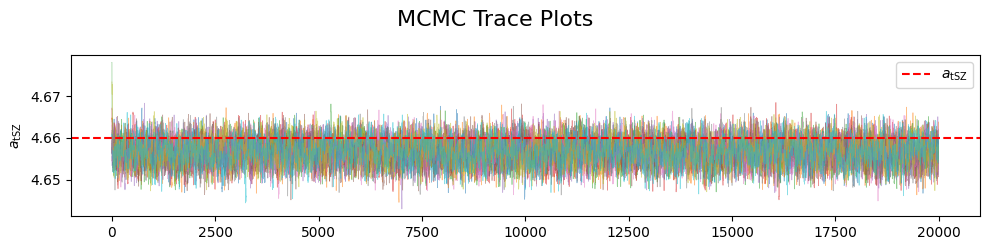

In [42]:
chains = sampler.get_chain()

n_steps, n_walkers, ndim = chains.shape

fig, axes = plt.subplots(ndim, 1, figsize=(10, 2.5 * ndim), sharex=True)

for i in range(ndim):
    ax = axes
    for walker in range(n_walkers):
        ax.plot(chains[:, walker, i], alpha=0.5, lw=0.5)
    ax.set_ylabel(labels[i])
    ax.axhline(a_true[i], color='r', linestyle='--', label=labels[i])
    ax.legend(loc='upper right')

plt.suptitle("MCMC Trace Plots", fontsize=16)
plt.tight_layout()
plt.show()

TypeError: 'Axes' object is not subscriptable

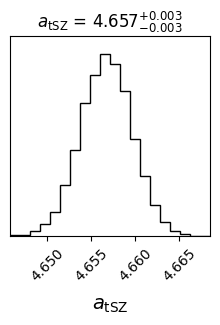

In [44]:

# 1. Plot the corner with truths and titles
figure = corner.corner(
    samples,
    labels=labels,
    truths=a_true,
    label_kwargs={"fontsize": 14},
    show_titles=True,
    title_fmt=".3f",
    title_kwargs={"fontsize": 12}
)

# 2. Add overall title
plt.suptitle(f"{centerfreqs}", fontsize=16, y=1.02)

# 3. Format axes to avoid floating offset junk
formatter = ScalarFormatter(useOffset=False)
for ax in figure.get_axes():
    ax.xaxis.set_major_formatter(formatter)
    ax.yaxis.set_major_formatter(formatter)

# 4. Annotate σ on diagonal (1D histogram) subplots
ndim = samples.shape[1]
for i in range(ndim):
    ax = figure.axes[i * ndim + i]  # diagonal subplot index
    mean = np.mean(samples[:, i])
    std = np.std(samples[:, i])
    
    # Add annotation text just below the axis
    ax.annotate(
        rf"$\sigma = {std:.3g}$",
        xy=(0.5, -0.3), xycoords="axes fraction",
        ha="center", va="center", fontsize=11
    )

# 5. Adjust layout to avoid overlaps
plt.tight_layout(pad=2.0)
plt.subplots_adjust(left=0.15, bottom=0.15, top=0.88)

plt.show()

# 6. Print summary to console
for i, label in enumerate(labels):
    mean = np.mean(samples[:, i])
    std = np.std(samples[:, i])
    print(f"{label}: {mean:.3f} ± {std:.3f}")